In [10]:
% pylab inline

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

Populating the interactive namespace from numpy and matplotlib


In [11]:
train = pd.read_csv('../input/Train.csv')

In [12]:
train['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [13]:
train['Outlet_Establishment_Year'].unique()

array([1999, 2009, 1998, 1987, 1985, 2002, 2007, 1997, 2004])

In [14]:
train['Outlet_Size'].unique()

array(['Medium', nan, 'High', 'Small'], dtype=object)

In [15]:
train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


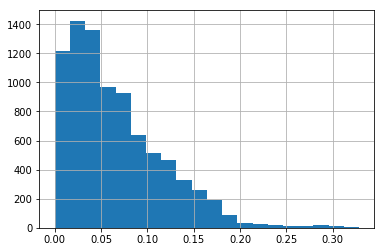

In [16]:
train['Item_Visibility'].hist(bins=20)

In [17]:
train['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [18]:
train['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

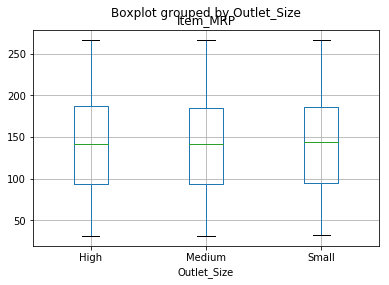

In [19]:
train.boxplot(column='Item_MRP', by='Outlet_Size')

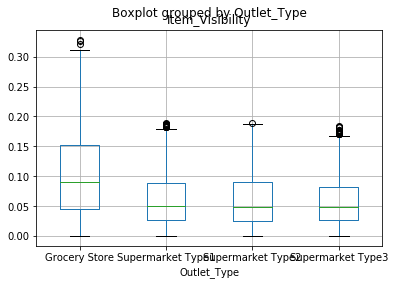

In [20]:
train.boxplot(column='Item_Visibility', by='Outlet_Type')

In [21]:
train['Outlet_Size'].mode()[0]

'Medium'

In [22]:
# fill the na for outlet size with medium
train['Outlet_Size'] = train['Outlet_Size'].fillna(train['Outlet_Size'].mode()[0])

In [23]:
# fill the na for item weight with the mean of weights
train['Item_Weight'] = train['Item_Weight'].fillna(train['Item_Weight'].mean())

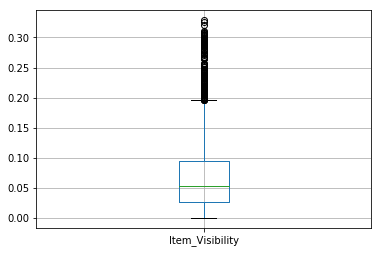

In [24]:
train.boxplot(column='Item_Visibility')

In [25]:
# delete the observations

Q1 = train['Item_Visibility'].quantile(0.25)
Q3 = train['Item_Visibility'].quantile(0.75)
IQR = Q3 - Q1
filt_train = train.query('(@Q1 - 1.5 * @IQR) <= Item_Visibility <= (@Q3 + 1.5 * @IQR)')

In [26]:
filt_train.shape, train.shape

((8379, 12), (8523, 12))

In [27]:
train = filt_train
train.shape

(8379, 12)

In [28]:
train['Item_Visibility_bins'] = pd.cut(train['Item_Visibility'], [0.000, 0.065, 0.13, 0.2], labels=['Low Viz', 'Viz', 'High Viz'])

In [29]:
train['Item_Visibility_bins'] = train['Item_Visibility_bins'].replace(NaN, 'Low Viz')

In [30]:
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace(['low fat', 'LF'], 'Low Fat')

In [31]:
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace('reg', 'Regular')

In [32]:
#choosing the Fat content, item vizibility bins, outlet size, loc type and type for LABEL ENCODER

In [33]:
le = LabelEncoder()

In [34]:
train['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

In [35]:
train['Item_Fat_Content'] = le.fit_transform(train['Item_Fat_Content'])

In [36]:
train['Item_Visibility_bins'] = le.fit_transform(train['Item_Visibility_bins'])

In [37]:
train['Outlet_Size'] = le.fit_transform(train['Outlet_Size'])

In [38]:
train['Outlet_Location_Type'] = le.fit_transform(train['Outlet_Location_Type'])

In [39]:
# create dummies for outlet type

In [40]:
dummy = pd.get_dummies(train['Outlet_Type'])
dummy.head()

,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
0,0,1,0,0
1,0,0,1,0
2,0,1,0,0
3,1,0,0,0
4,0,1,0,0


In [41]:
train = pd.concat([train, dummy], axis=1)

In [42]:
# in linear regression that correlated features should not be present

train.corr()[((train.corr() < -0.85) | (train.corr() > 0.85)) & (train.corr() != 1)]

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Item_Outlet_Sales,Item_Visibility_bins,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Item_Weight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Item_Fat_Content,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Item_Visibility,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Item_MRP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Outlet_Establishment_Year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Outlet_Size,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Outlet_Location_Type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Item_Outlet_Sales,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Item_Visibility_bins,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Grocery Store,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
train.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content               int64
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                    int64
Outlet_Location_Type           int64
Outlet_Type                   object
Item_Outlet_Sales            float64
Item_Visibility_bins           int64
Grocery Store                  uint8
Supermarket Type1              uint8
Supermarket Type2              uint8
Supermarket Type3              uint8
dtype: object

In [44]:
# got to drop all the object types features
train = train.drop(['Item_Identifier', 'Item_Type', 'Outlet_Identifier', 'Outlet_Type'], axis=1)

In [45]:
train.columns

Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Item_Outlet_Sales', 'Item_Visibility_bins', 'Grocery Store',
       'Supermarket Type1', 'Supermarket Type2', 'Supermarket Type3'],
      dtype='object')

In [46]:
# build the linear regression model
X = train.drop('Item_Outlet_Sales', axis=1)
y = train.Item_Outlet_Sales

In [47]:
test = pd.read_csv('../input/Test.csv')
test['Outlet_Size'] = test['Outlet_Size'].fillna('Medium')

In [48]:
test['Item_Visibility_bins'] = pd.cut(test['Item_Visibility'], [0.000, 0.065, 0.13, 0.2], labels=['Low Viz', 'Viz', 'High Viz'])

In [49]:
test['Item_Weight'] = test['Item_Weight'].fillna(test['Item_Weight'].mean())

In [50]:
test['Item_Visibility_bins'] = test['Item_Visibility_bins'].replace(NaN, 'Low Viz')
test['Item_Visibility_bins'].head()

0    Low Viz
1    Low Viz
2        Viz
3    Low Viz
4        Viz
Name: Item_Visibility_bins, dtype: category
Categories (3, object): [Low Viz < Viz < High Viz]

In [51]:
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace(['low fat', 'LF'], 'Low Fat')
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace('reg', 'Regular')

In [52]:
test['Item_Fat_Content'] = le.fit_transform(test['Item_Fat_Content'])

In [53]:
test['Item_Visibility_bins'] = le.fit_transform(test['Item_Visibility_bins'])

In [54]:
test['Outlet_Size'] = le.fit_transform(test['Outlet_Size'])

In [55]:
test['Outlet_Location_Type'] = le.fit_transform(test['Outlet_Location_Type'])

In [56]:
dummy = pd.get_dummies(test['Outlet_Type'])
test = pd.concat([test, dummy], axis=1)

In [57]:
X_test = test.drop(['Item_Identifier', 'Item_Type', 'Outlet_Identifier', 'Outlet_Type'], axis=1)

In [58]:
X.columns, X_test.columns

(Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_MRP',
        'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
        'Item_Visibility_bins', 'Grocery Store', 'Supermarket Type1',
        'Supermarket Type2', 'Supermarket Type3'],
       dtype='object'),
 Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_MRP',
        'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
        'Item_Visibility_bins', 'Grocery Store', 'Supermarket Type1',
        'Supermarket Type2', 'Supermarket Type3'],
       dtype='object'))

In [59]:
lin = LinearRegression()

In [60]:
lin.fit(X, y)
predictions = lin.predict(X_test)

In [61]:
# create submission file
submission1 = pd.DataFrame(data=[], columns=['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales'])
submission1['Item_Identifier'] = test['Item_Identifier']
submission1['Outlet_Identifier'] = test['Outlet_Identifier']
submission1['Item_Outlet_Sales'] = predictions
submission1.to_csv('submission1.csv', index=False)
submission1.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1775.267791
1,FDW14,OUT017,1517.194705
2,NCN55,OUT010,1933.945314
3,FDQ58,OUT017,2543.860693
4,FDY38,OUT027,5204.043635


In [62]:
# decision tree
dtree_class = DecisionTreeClassifier(criterion='gini', max_depth=25)
y = y.astype(int)

In [63]:
dtree_class.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=25,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [64]:
accuracy_score(y, dtree_class.predict(X))

0.9883040935672515

In [65]:
r2_score(y, dtree_class.predict(X))

0.9836511818844509

In [66]:
pred = dtree_class.predict(X_test)
pred

array([1693, 1230,  484, ...,  353, 3419, 1651])

In [67]:
# # create submission file
# submission = pd.DataFrame(data=[], columns=['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales'])
# submission['Item_Identifier'] = test['Item_Identifier']
# submission['Outlet_Identifier'] = test['Outlet_Identifier']
# submission['Item_Outlet_Sales'] = pred
# submission.to_csv('submission.csv', index=False)
# submission.head()

In [68]:
dtree_reg = DecisionTreeRegressor(criterion='mse', max_depth=10)

In [69]:
dtree_reg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [70]:
pred = dtree_reg.predict(X_test)
pred

array([1683.86774194, 1283.09466019,  597.94545455, ..., 1808.80246914,
       5011.77777778, 1283.09466019])

In [71]:
# # create submission file
# submission = pd.DataFrame(data=[], columns=['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales'])
# submission['Item_Identifier'] = test['Item_Identifier']
# submission['Outlet_Identifier'] = test['Outlet_Identifier']
# submission['Item_Outlet_Sales'] = pred
# submission.to_csv('submission2.csv', index=False)
# submission.head()

In [72]:
cross_val_score(lin, X, y, cv=5, scoring='r2')

array([0.56695129, 0.54844669, 0.5434969 , 0.56014671, 0.55995928])

In [73]:
cross_val_score(dtree_reg, X, y, cv=5, scoring='r2')

array([0.52444253, 0.51791075, 0.47384708, 0.50782669, 0.53640147])

In [74]:
# cross_val_score(dtree_class, X, y, cv=5, scoring='roc_auc') - results in an error

In [75]:
r2_score(y, lin.predict(X))

0.5577422609071079

In [76]:
r2_score(y, dtree_reg.predict(X))

0.6718952242298817

In [77]:
avg_pred = (lin.predict(X) + dtree_reg.predict(X)) / 2

In [78]:
r2_score(y, avg_pred)

0.6437695983677753

In [79]:
wavg_pred = lin.predict(X)*0.1 + dtree_reg.predict(X)*0.9

In [80]:
r2_score(y, wavg_pred)

0.6709022359853452

In [81]:
rmf = RandomForestClassifier(n_estimators=100, max_depth=10)

In [ ]:
rmf.fit(X, y)

In [ ]:
r2_score(y, rmf.predict(X))

In [ ]:
accuracy_score(y, rmf.predict(X))